This file contains python code to generate data for comparing with sinica paper

Note the method from sinica paper does not consider the covariate and intercept, 

moreover, it is std across the sample size

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper

from joblib import Parallel, delayed

In [4]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

# Param and fns

## Params

In [6]:
def gram_schmidt(vectors):
    vectors = vectors.T
    basis = []
    for v in vectors:
        for b in basis:
            v = v - (np.dot(v, b) / np.dot(b, b)) * b 
        if np.linalg.norm(v) > 1e-10:  
            basis.append(v / np.linalg.norm(v))  
    return np.array(basis).T

In [7]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 1000 
paras.freqs = np.linspace(2, 45, 40) # freqs

# generating dataset
paras.n = 200 # num of data obs to be genareted
paras.npts = len(paras.freqs) # num of pts to evaluate X(s)
paras.d = 50 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 0.0 # variance of the error
paras.types_ = ["int"]

# b-spline
paras.N = 8 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
basis_mat = obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord)
paras.basis_mat = torch.tensor(basis_mat).to(torch.get_default_dtype())
paras.org_basis_mat = gram_schmidt(basis_mat) # only for Sinica
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([0])

# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
paras.fourier_basis_coefs = ([coef_fn(0.5), coef_fn(0.3), coef_fn(0.1)] + 
                             [np.zeros(50)] * (paras.d-3) 
                             #[coef_fn(0.7), coef_fn(0.9)]
                             )
#paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs #* 100
paras.eta_gt = paras.beta_GT.T @ paras.org_basis_mat;

The number of B-spline basis is 8.


## Fns

In [8]:
def _is_exists(d, n, seed):
    """
    Check if a file with the given parameters exists.

    Args:
    d (int): The value of d in the file name.
    n (int): The value of n in the file name.
    seed (int): The seed value in the file name.

    Returns:
    bool or Path: Returns the file path if the file exists, otherwise returns False.
    """
    _get_n = lambda fil: int(fil.stem.split("-")[-1])
    fils = MIDRES_ROOT.glob(f"PSD_d-{d}_n*")
    # We do not need fil with n as we know the data with corresponding seed does not exist
    fils = [fil for fil in fils if _get_n(fil) !=n]
    if len(fils) == 0:
        return False
    else:
        fils = sorted(fils, key=_get_n)
        ns = np.array([_get_n(fil) for fil in fils])
        idxs = np.where(n <= ns)[0]
        if len(idxs) == 0:
            return False
        else:
            fil =fils[idxs[0]]
            path = MIDRES_ROOT/fil/f"seed_{seed}.pkl"
            return path if path.exists() else False
def _get_filename(params):
    keys = ["d", "n", "sn"]
    folder_name = 'PSD_sinica_'+'_'.join(f"{k}-{params[k]}" for k in keys)
    return folder_name + f'/seed_{params.seed}.pkl'

def _gen_simu_data_sinica(seed, paras, verbose=True, is_gen=False):
    """
    Generate simulated data for all parameters (including data for sinica paper)

    Args:
        seed (int): Seed for random number generator.
        paras (dict): Dictionary containing the following parameters:
            - n (int): Number of samples.
            - d (int): Number of dimensions.
            - q (int): Number of covariates.
            - types_ (list): List of types for generating covariates.
            - alp_GT (list): List of ground truth alpha values.
            - beta_GT (list): List of ground truth beta values.
            - freqs (list): List of frequencies for generating simulated PSD.
            - sigma2 (float): Variance of the noise.
        verbose(bool): Verbose or not
        is_gen(bool): Only for generating or not. If True, only checking or generating X, not return anything.

    Returns:
        HDF_data (dict): Dictionary containing the following simulated data:
            - X (torch.Tensor): Tensor of shape (n, d, npts) containing the simulated PSD.
            - Y (torch.Tensor): Tensor of shape (n,) containing the response variable.
            - Z (torch.Tensor): Tensor of shape (n, q) containing the covariates.
        sinica_data (dict)
    """
    np.random.seed(seed)
    _paras = edict(paras.copy())
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.sn = _paras.N
    
    file_path = MIDRES_ROOT/_get_filename(tmp_paras)
    if file_path.exists():
        if is_gen:
            return None
        simu_curvs = load_pkl(file_path, verbose=verbose)
    else:
        ofil =  _is_exists(_paras.d, _paras.n, seed)
        if ofil:
            if is_gen:
                return None
            simu_curvs = load_pkl(ofil, verbose=verbose)
        else:
            simu_curvs = gen_simu_psd(_paras.n, _paras.d, _paras.freqs, prior_sd=10, n_jobs=20, is_prog=False, is_std=False)
            save_pkl(file_path, simu_curvs, verbose=verbose)
    if is_gen:
        return None
    
    simu_curvs = simu_curvs[:_paras.n]
    print(simu_curvs.shape)
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts)
    simu_curvs_std = (simu_curvs - simu_curvs.mean(axis=0, keepdims=True))/simu_curvs.std(axis=0, keepdims=True);
    
    simu_covs = gen_covs(_paras.n, _paras.types_)
        
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs_std[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
        
    # linear term, no cov_part, only integration
    lin_term = cov_part + int_part
        
    # Y 
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # for Sinica paper, transform PSD to theta and center Y
    Y_centered = Y - Y.mean(axis=0, keepdims=True)
    solve_part = np.linalg.inv(_paras.org_basis_mat.T @ _paras.org_basis_mat) @ _paras.org_basis_mat.T;
    thetas = np.array([tX @ solve_part.T for tX in simu_curvs_std]).transpose(1, 0, 2);
    sinica_data = {'thetas': [theta for theta in thetas],  
                   'Y_centered':Y_centered, 
                   'basis': _paras.org_basis_mat,
                   'tXs':simu_curvs_std}
        
    # To torch
    X = torch.Tensor(simu_curvs_std) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x 1, intercept only
    Y = torch.Tensor(Y);
    
    HDF_data = edict()
    HDF_data.X = X
    HDF_data.Y = Y
    HDF_data.Z = Z
    HDF_data.lin_term = lin_term
    return HDF_data, edict(sinica_data)
    

In [9]:
a, b = _gen_simu_data_sinica(1, paras, verbose=False, is_gen=False);

(200, 50, 40)


In [10]:
i = 1 # sps idx
j = 49 # fn idx
k = 3 # sn idx
rec = paras.org_basis_mat @ b.thetas[j][i]
org = b.tXs[i, j];

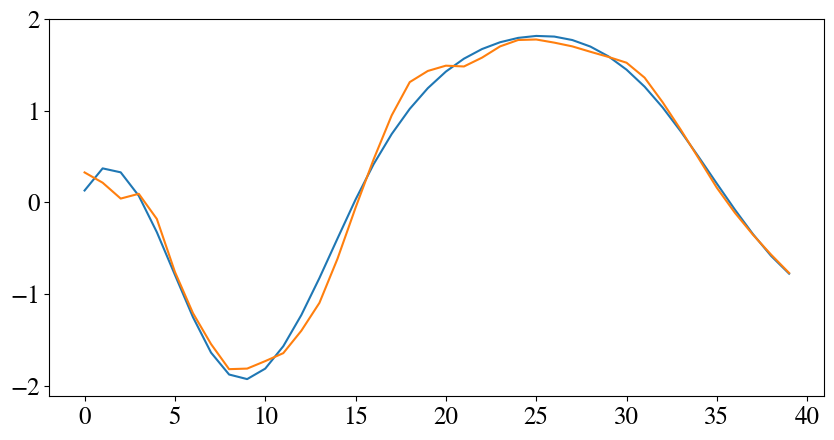

In [11]:
plt.plot(rec)
plt.plot(org)

# Generate data
To avoid nested joblib

In [12]:
from scipy.io import savemat
def _get_filename_mat(params, seed):
    params = edict(params.copy())
    params.sn = params.N
    keys = ["d", "n", "sn"]
    folder_name = 'PSD_sinica_'+'_'.join(f"{k}-{params[k]}" for k in keys)
    folder_name = MIDRES_ROOT/f"matlab_simu_data/{folder_name}"
    if not folder_name.exists():
        folder_name.mkdir()
    return folder_name /f'H1_seed_{seed}.mat'

for seed in range(1, 2):
#for seed in trange(paras.num_rep):
    _, sinica_data = _gen_simu_data_sinica(seed, paras, verbose=False, is_gen=False)
    savemat(_get_filename_mat(paras, seed), sinica_data)

(200, 50, 40)
